# 1: Setup and Package Import

In [2]:
import openmc
# import openmc.plotter
import paramak
from cad_to_dagmc import CadToDagmc
from pathlib import Path
from IPython.display import Image, display # For displaying plots
import numpy as np
import matplotlib.pyplot as plt
import neutronics_material_maker as nmm

# --- Step 0: Setup ---
# Set path for cross-sections.
openmc.config['cross_sections'] = Path.home() / 'nuclear_data' / 'cross_sections.xml'
print(f"Set openmc.config['cross_sections'] to {openmc.config['cross_sections']}")

# --- NEW: Define and create the output directory ---
output_dir = Path.cwd().parent / "outputs"
print(output_dir)
output_dir.mkdir(parents=True, exist_ok=True)
print(f"All outputs will be saved to: {output_dir}")

Set openmc.config['cross_sections'] to /home/vk/nuclear_data/cross_sections.xml
/home/vk/fusion-neutronics-modelling/outputs
All outputs will be saved to: /home/vk/fusion-neutronics-modelling/outputs


# 2: Paramak Model

In [14]:
# --- 1. Global Component Dictionary ---
# Maps layer ID to ((R,G,B,A), "Nicer Name")
# This is now the single source of truth for colors and names.

COMPONENT_MAP = {
    'layer_1': ((0.4, 0.9, 0.4), "centre_column"),
    'layer_2': ((0.6, 0.8, 0.6), "magnet_shield"),
    'layer_3': ((0.1, 0.8, 0.6), "first_wall"),
    'layer_4': ((0.1, 0.1, 0.9), "breeder"),
    'layer_5': ((0.4, 0.4, 0.8), "rear_wall"),
    'plasma':  ((1.0, 0.7, 0.8, 0.6), "plasma"),
}

paramak_colors = {
    name: details[0] for name, details in COMPONENT_MAP.items()
}

In [4]:
def basic_tokamak(paramak_colors, a = (100), t = 0.55):

    radial_build_list = [
        (paramak.LayerType.GAP, 10),
        (paramak.LayerType.SOLID, 30),
        (paramak.LayerType.SOLID, 50),
        (paramak.LayerType.SOLID, 10),
        (paramak.LayerType.SOLID, (a / 100) * (2/3) * 70),  # breeder
        (paramak.LayerType.SOLID, 20),
        (paramak.LayerType.GAP, 60),
        (paramak.LayerType.PLASMA, 300),
        (paramak.LayerType.GAP, 60),
        (paramak.LayerType.SOLID, 20),
        (paramak.LayerType.SOLID, (a / 100) * (2/3) * 110),  # breeder
        (paramak.LayerType.SOLID, 10),
    ]

    vertical_build_list = [
        (paramak.LayerType.SOLID, 15),
        (paramak.LayerType.SOLID, (a / 100) * (2/3) * 80),  # breeder
        (paramak.LayerType.SOLID, 10),
        (paramak.LayerType.GAP, 50),
        (paramak.LayerType.PLASMA, 700),
        (paramak.LayerType.GAP, 60),
        (paramak.LayerType.SOLID, 10),
        (paramak.LayerType.SOLID, (a / 100) * (2/3) * 40),  # breeder
        (paramak.LayerType.SOLID, 15),
    ]

    my_reactor = paramak.tokamak(
        radial_build=radial_build_list,
        vertical_build=vertical_build_list,
        triangularity=t,
        rotation_angle=180,
        colors=paramak_colors
    )

    reactor_material_tags = my_reactor.names()
    reactor_material_tags[2] = 'eurofer' # required to ensure that the EUROFER first wall is properly parsed


    return (my_reactor, reactor_material_tags, radial_build_list)



Execution Cell ↓

In [ ]:


my_reactor, reactor_material_tags, radial_build_list = basic_tokamak(paramak_colors)

my_reactor

# 3: Conversion to DAGMC

In [5]:
def converter_code(my_reactor, reactor_material_tags):
    print("Converting CAD to DAGMC...")
    converter = CadToDagmc()

    # Add the CadQuery assembly from the Paramak object
    converter.add_cadquery_object(
        my_reactor,
        material_tags=reactor_material_tags
    )

    h5m_filename = output_dir / "dagmc_reactor.h5m"

    # Export the DAGMC .h5m file
    converter.export_dagmc_h5m_file(
        filename=str(h5m_filename),
        max_mesh_size=20.0,
        min_mesh_size=2.0
    )
    print(f"Successfully created {h5m_filename}")

    return (h5m_filename)


Execution Cell ↓

In [ ]:
h5m_filename = converter_code(my_reactor, reactor_material_tags)

# Liquid Breeder Materials List

In [6]:
Li = openmc.Material()
Li.add_element('Li',
     1,
    percent_type = 'ao',
    enrichment = 60,
    enrichment_target = 'Li6',
    enrichment_type = 'ao')
Li.set_density('g/cm3', 0.512)


Li17Pb83 = openmc.Material()
Li17Pb83.add_element('Li',
     17,
    percent_type = 'ao',
    enrichment = 60,
    enrichment_target = 'Li6',
    enrichment_type = 'ao')
Li17Pb83.add_element('Pb', 83)
Li17Pb83.set_density('g/cm3', 11)


LiF_BeF2_1 = openmc.Material()
LiF_BeF2_1.add_element('Li',
     2,
    percent_type = 'ao',
    enrichment = 60,
    enrichment_target = 'Li6',
    enrichment_type = 'ao')
LiF_BeF2_1.add_element('Be', 1)
LiF_BeF2_1.add_element('F', 4)
LiF_BeF2_1.set_density('g/cm3', 2.04)


LiF_BeF2_2 = openmc.Material()
LiF_BeF2_2.add_element('Li',
     1,
    percent_type = 'ao',
    enrichment = 60,
    enrichment_target = 'Li6',
    enrichment_type = 'ao')
LiF_BeF2_2.add_element('Be', 1)
LiF_BeF2_2.add_element('F', 3)
LiF_BeF2_2.set_density('g/cm3', 2.06)


LiF_PbF2 = openmc.Material()
LiF_PbF2.add_element('Li',
     2,
    percent_type = 'ao',
    enrichment = 60,
    enrichment_target = 'Li6',
    enrichment_type = 'ao')
LiF_PbF2.add_element('F', 8)
LiF_PbF2.add_element('Pb', 3)
LiF_PbF2.set_density('g/cm3', 3.55)


Li3N = openmc.Material()
Li3N.add_element('Li',
     3,
    percent_type = 'ao',
    enrichment = 60,
    enrichment_target = 'Li6',
    enrichment_type = 'ao')
Li3N.add_element('N', 1)
Li3N.set_density('g/cm3', 1.30)

LiF = openmc.Material()
LiF.add_element('Li',
     2,
    percent_type = 'ao',
    enrichment = 60,
    enrichment_target = 'Li6',
    enrichment_type = 'ao')
LiF.add_element('F', 1)
LiF.set_density('g/cm3', 2.64)


LiF_BeF2_NaF = openmc.Material()
LiF_BeF2_NaF.add_element('Li',
     1,
    percent_type = 'ao',
    enrichment = 60,
    enrichment_target = 'Li6',
    enrichment_type = 'ao')
LiF_BeF2_NaF.add_element('F', 4)
LiF_BeF2_NaF.add_element('Na', 1)
LiF_BeF2_NaF.add_element('Be', 1)
LiF_BeF2_NaF.set_density('g/cm3', 2.15)


LiF_NaF_ZrF4 = openmc.Material()
LiF_NaF_ZrF4.add_element('Li',
     55,
    percent_type = 'ao',
    enrichment = 60,
    enrichment_target = 'Li6',
    enrichment_type = 'ao')
LiF_NaF_ZrF4.add_element('F', 169)
LiF_NaF_ZrF4.add_element('Na', 22)
LiF_NaF_ZrF4.add_element('Zr', 23)
LiF_NaF_ZrF4.set_density('g/cm3', 2.72)


LiF_NaF_KF = openmc.Material()
LiF_NaF_KF.add_element('Li',
     46.5,
    percent_type = 'ao',
    enrichment = 60,
    enrichment_target = 'Li6',
    enrichment_type = 'ao')
LiF_NaF_KF.add_element('F', 100)
LiF_NaF_KF.add_element('Na', 11.5)
LiF_NaF_KF.add_element('K', 42)
LiF_NaF_KF.set_density('g/cm3', 2.02)


LiCl_NaCl = openmc.Material()
LiCl_NaCl.add_element('Li',
     72,
    percent_type = 'ao',
    enrichment = 60,
    enrichment_target = 'Li6',
    enrichment_type = 'ao')
LiCl_NaCl.add_element('Cl', 100)
LiCl_NaCl.add_element('Na', 28)
LiCl_NaCl.set_density('g/cm3', 1.52)


LiCl_KCl_1 = openmc.Material()
LiCl_KCl_1.add_element('Li',
     7,
    percent_type = 'ao',
    enrichment = 60,
    enrichment_target = 'Li6',
    enrichment_type = 'ao')
LiCl_KCl_1.add_element('Cl', 10)
LiCl_KCl_1.add_element('K', 3)
LiCl_KCl_1.set_density('g/cm3', 1.51)


LiCl_KCl_2 = openmc.Material()
LiCl_KCl_2.add_element('Li',
     52,
    percent_type = 'ao',
    enrichment = 60,
    enrichment_target = 'Li6',
    enrichment_type = 'ao')
LiCl_KCl_2.add_element('Cl', 100)
LiCl_KCl_2.add_element('K',48)
LiCl_KCl_2.set_density('g/cm3', 1.51)


LiCl_BeCl2 = openmc.Material()
LiCl_BeCl2.add_element('Li',
     1,
    percent_type = 'ao',
    enrichment = 60,
    enrichment_target = 'Li6',
    enrichment_type = 'ao')
LiCl_BeCl2.add_element('Cl', 3)
LiCl_BeCl2.add_element('Be',1)
LiCl_BeCl2.set_density('g/cm3', 1.52)


LiF_LiI2 = openmc.Material()
LiF_LiI2.add_element('Li',
     100,
    percent_type = 'ao',
    enrichment = 60,
    enrichment_target = 'Li6',
    enrichment_type = 'ao')
LiF_LiI2.add_element('F', 83.5)
LiF_LiI2.add_element('I',33)
LiF_LiI2.set_density('g/cm3', 3.68)


LiCl_PbCl2 = openmc.Material()
LiCl_PbCl2.add_element('Li',
     1,
    percent_type = 'ao',
    enrichment = 60,
    enrichment_target = 'Li6',
    enrichment_type = 'ao')
LiCl_PbCl2.add_element('Pb', 2)
LiCl_PbCl2.add_element('Cl',5)
LiCl_PbCl2.set_density('g/cm3', 4.50)


LiF_LiBr_NaF = openmc.Material()
LiF_LiBr_NaF.add_element('Li',
     93,
    percent_type = 'ao',
    enrichment = 60,
    enrichment_target = 'Li6',
    enrichment_type = 'ao')
LiF_LiBr_NaF.add_element('F', 21)
LiF_LiBr_NaF.add_element('Br',79)
LiF_LiBr_NaF.add_element('Na',7)
LiF_LiBr_NaF.set_density('g/cm3', 3.20)


LiF_LiBr_NaBr = openmc.Material()
LiF_LiBr_NaBr.add_element('Li',
     93,
    percent_type = 'ao',
    enrichment = 60,
    enrichment_target = 'Li6',
    enrichment_type = 'ao')
LiF_LiBr_NaBr.add_element('F', 20)
LiF_LiBr_NaBr.add_element('Br',80)
LiF_LiBr_NaBr.add_element('Na',7)
LiF_LiBr_NaBr.set_density('g/cm3', 3.16)


liquid_breeders = [Li, Li17Pb83, LiF_BeF2_1, LiF_BeF2_2, LiF_PbF2, Li3N, LiF, LiF_BeF2_NaF, LiF_NaF_ZrF4, LiF_NaF_KF, LiCl_NaCl, LiCl_KCl_1, LiCl_KCl_2, LiCl_BeCl2, LiF_LiI2, LiCl_PbCl2, LiF_LiBr_NaF, LiF_LiBr_NaBr]
liquid_names = ['Li', 'Li17Pb83', 'LiF_BeF2', 'Li_BeF2*', 'LiF_PbF2', 'Li3N', 'LiF', 'LiF_BeF2_NaF', 'LiF_NaF_ZrF4', 'LiF_NaF_KF', 'LiCl_NaCl', 'LiCl_KCl', 'LiCl_KCl*', 'LiCl_BeCl2', 'LiF_LiI2', 'LiCl_PbCl2', 'LiF_LiBr_NaF', 'LiF_LiBr_NaBr']

# Solid Breeder Materials List

In [7]:
Li2O = openmc.Material()
Li2O.add_element('Li',
     2,
    percent_type = 'ao',
    enrichment = 60,
    enrichment_target = 'Li6',
    enrichment_type = 'ao')
Li2O.add_element('O', 1)
Li2O.set_density('g/cm3', 2.10)


Li4SiO4 = openmc.Material()
Li4SiO4.add_element('Li',
     4,
    percent_type = 'ao',
    enrichment = 60,
    enrichment_target = 'Li6',
    enrichment_type = 'ao')
Li4SiO4.add_element('O', 4)
Li4SiO4.add_element('Si', 1)
Li4SiO4.set_density('g/cm3', 2.4)


Li2TiO3 = openmc.Material()
Li2TiO3.add_element('Li',
     2,
    percent_type = 'ao',
    enrichment = 60,
    enrichment_target = 'Li6',
    enrichment_type = 'ao')
Li2TiO3.add_element('O', 3)
Li2TiO3.add_element('Ti', 1)
Li2TiO3.set_density('g/cm3', 3.43)


Li8PbO6 = openmc.Material()
Li8PbO6.add_element('Li',
     8,
    percent_type = 'ao',
    enrichment = 60,
    enrichment_target = 'Li6',
    enrichment_type = 'ao')
Li8PbO6.add_element('O', 6)
Li8PbO6.add_element('Pb', 1)
Li8PbO6.set_density('g/cm3', 4.28)


Li8SiO6 = openmc.Material()
Li8SiO6.add_element('Li',
     8,
    percent_type = 'ao',
    enrichment = 60,
    enrichment_target = 'Li6',
    enrichment_type = 'ao')
Li8SiO6.add_element('O', 6)
Li8SiO6.add_element('Si', 1)
Li8SiO6.set_density('g/cm3', 2.20)


Li8CoO6 = openmc.Material()
Li8CoO6.add_element('Li',
     8,
    percent_type = 'ao',
    enrichment = 60,
    enrichment_target = 'Li6',
    enrichment_type = 'ao')
Li8CoO6.add_element('O', 6)
Li8CoO6.add_element('Co', 1)
Li8CoO6.set_density('g/cm3', 2.47)


Li8GeO6 = openmc.Material()
Li8GeO6.add_element('Li',
     8,
    percent_type = 'ao',
    enrichment = 60,
    enrichment_target = 'Li6',
    enrichment_type = 'ao')
Li8GeO6.add_element('O', 6)
Li8GeO6.add_element('Ge', 1)
Li8GeO6.set_density('g/cm3', 2.64)


Li8ZrO6 = openmc.Material()
Li8ZrO6.add_element('Li',
     8,
    percent_type = 'ao',
    enrichment = 60,
    enrichment_target = 'Li6',
    enrichment_type = 'ao')
Li8ZrO6.add_element('O', 6)
Li8ZrO6.add_element('Zr', 1)
Li8ZrO6.set_density('g/cm3', 2.98)


Li8SnO6 = openmc.Material()
Li8SnO6.add_element('Li',
     8,
    percent_type = 'ao',
    enrichment = 60,
    enrichment_target = 'Li6',
    enrichment_type = 'ao')
Li8SnO6.add_element('O', 6)
Li8SnO6.add_element('Sn', 1)
Li8SnO6.set_density('g/cm3', 3.41)


Li8CeO6 = openmc.Material()
Li8CeO6.add_element('Li',
     8,
    percent_type = 'ao',
    enrichment = 60,
    enrichment_target = 'Li6',
    enrichment_type = 'ao')
Li8CeO6.add_element('O', 6)
Li8CeO6.add_element('Ce', 1)
Li8CeO6.set_density('g/cm3', 3.25)


Li6MnO4 = openmc.Material()
Li6MnO4.add_element('Li',
     6,
    percent_type = 'ao',
    enrichment = 60,
    enrichment_target = 'Li6',
    enrichment_type = 'ao')
Li6MnO4.add_element('O', 4)
Li6MnO4.add_element('Mn', 1)
Li6MnO4.set_density('g/cm3', 2.50)


Li6CoO4 = openmc.Material()
Li6CoO4.add_element('Li',
     6,
    percent_type = 'ao',
    enrichment = 60,
    enrichment_target = 'Li6',
    enrichment_type = 'ao')
Li6CoO4.add_element('O', 4)
Li6CoO4.add_element('Co', 1)
Li6CoO4.set_density('g/cm3', 2.77)


Li6ZnO4 = openmc.Material()
Li6ZnO4.add_element('Li',
     6,
    percent_type = 'ao',
    enrichment = 60,
    enrichment_target = 'Li6',
    enrichment_type = 'ao')
Li6ZnO4.add_element('O', 4)
Li6ZnO4.add_element('Zn', 1)
Li6ZnO4.set_density('g/cm3', 2.86)


Li6Zr2O7 = openmc.Material()
Li6Zr2O7.add_element('Li',
     6,
    percent_type = 'ao',
    enrichment = 60,
    enrichment_target = 'Li6',
    enrichment_type = 'ao')
Li6Zr2O7.add_element('O', 7)
Li6Zr2O7.add_element('Zr', 2)
Li6Zr2O7.set_density('g/cm3', 3.56)


Li5AlO4 = openmc.Material()
Li5AlO4.add_element('Li',
     5,
    percent_type = 'ao',
    enrichment = 60,
    enrichment_target = 'Li6',
    enrichment_type = 'ao')
Li5AlO4.add_element('O', 4)
Li5AlO4.add_element('Al', 1)
Li5AlO4.set_density('g/cm3', 2.25)


Li5FeO4 = openmc.Material()
Li5FeO4.add_element('Li',
     5,
    percent_type = 'ao',
    enrichment = 60,
    enrichment_target = 'Li6',
    enrichment_type = 'ao')
Li5FeO4.add_element('O', 4)
Li5FeO4.add_element('Fe', 1)
Li5FeO4.set_density('g/cm3', 2.64)


Li4TiO4 = openmc.Material()
Li4TiO4.add_element('Li',
     4,
    percent_type = 'ao',
    enrichment = 60,
    enrichment_target = 'Li6',
    enrichment_type = 'ao')
Li4TiO4.add_element('O', 4)
Li4TiO4.add_element('Ti', 1)
Li4TiO4.set_density('g/cm3', 2.57)


Li4GeO4 = openmc.Material()
Li4GeO4.add_element('Li',
     4,
    percent_type = 'ao',
    enrichment = 60,
    enrichment_target = 'Li6',
    enrichment_type = 'ao')
Li4GeO4.add_element('O', 4)
Li4GeO4.add_element('Ge', 1)
Li4GeO4.set_density('g/cm3', 3.16)


Li2SiO3 = openmc.Material()
Li2SiO3.add_element('Li',
     2,
    percent_type = 'ao',
    enrichment = 60,
    enrichment_target = 'Li6',
    enrichment_type = 'ao')
Li2SiO3.add_element('O', 3)
Li2SiO3.add_element('Si', 1)
Li2SiO3.set_density('g/cm3', 2.53)


Li2MnO2 = openmc.Material()
Li2MnO2.add_element('Li',
     2,
    percent_type = 'ao',
    enrichment = 60,
    enrichment_target = 'Li6',
    enrichment_type = 'ao')
Li2MnO2.add_element('O', 2)
Li2MnO2.add_element('Mn', 1)
Li2MnO2.set_density('g/cm3', 2.53)


solid_breeders = [Li2O, Li4SiO4, Li2TiO3, Li8PbO6, Li8SiO6, Li8CoO6, Li8GeO6, Li8ZrO6, Li8SnO6, Li8CeO6, Li6MnO4, Li6CoO4, Li6ZnO4, Li6Zr2O7, Li5AlO4, Li5FeO4, Li4TiO4, Li4GeO4, Li2SiO3, Li2MnO2]
solid_names = ['Li2O', 'Li4SiO4', 'Li2TiO3', 'Li8PbO6', 'Li8SiO6', 'Li8CoO6', 'Li8GeO6', 'Li8ZrO6', 'Li8SnO6', 'Li8CeO6', 'Li6MnO4', 'Li6CoO4', 'Li6ZnO4', 'Li6Zr2O7', 'Li5AlO4', 'Li5FeO4', 'Li4TiO4', 'Li4GeO4', 'Li2SiO3', 'Li2MnO2']

# 4: Define Materials (One Material)

In [8]:
def materials_library(reactor_material_tags, e = 60, c = 0.36):
    # --- RESET AUTO IDs ---
    # This resets the internal counters for Material, Cell, and Surface IDs
    # to prevent them from increasing every time the cell is re-run.
    openmc.reset_auto_ids()
    # --------------------
    eurofer_mat = nmm.Material.from_library('eurofer')

    materials_list = []

    eurofer_mat = nmm.Material.from_library('eurofer')

    for tag in reactor_material_tags:
        # Create a new material with the *exact* name as the tag
        mat = openmc.Material(name=tag)

    # In a real model, you'd add specific elements based on the tag
    # The 'paramak.tokamak' builder tags the plasma as 'plasma'
    # and other layers as 'radial_layer_1', 'vertical_layer_1' etc.
        if tag == 'plasma':
            mat.add_nuclide('H3', 1.0, 'ao')
            mat.add_nuclide('H2', 1.0, 'ao')  # Dummy plasma
            mat.set_density('g/cm3', 1.0e-9)
        elif tag == 'layer_4':

            #breeder = openmc.Material()
            #breeder.add_element(
                #'Li',
                #0.17,
                #percent_type='ao',
                #enrichment=e,
                #enrichment_target='Li6',
                #enrichment_type='ao')
            #breeder.add_element('Pb', 0.83, 'ao')
            #breeder.set_density('g/cm3', 11)

            breeder = openmc.Material()
            breeder.add_element(
                'Li',
                17,
                percent_type = 'ao',
                enrichment = e,
                enrichment_target = 'Li6',
                enrichment_type = 'ao')
            breeder.add_element('Pb', 83, 'ao')
            breeder.set_density('g/cm3', 11)

            multiplier = openmc.Material()
            multiplier.add_element('Be', 12, 'ao')
            multiplier.add_element('Ti', 1, 'ao')
            multiplier.set_density('g/cm3', 2.28)

            coolant_he = nmm.Material.from_library(
                'He',
                temperature=800,
                pressure=8000000
            ).openmc_material

            coolant_h2o = nmm.Material.from_library(
                'H2O',
                temperature=600,
                pressure=15500000
            ).openmc_material

            coolant_n2 = nmm.Material.from_library(
                'nitrogen',
                temperature=600,
                pressure=1000000
            ).openmc_material

            enriched_water = openmc.Material()
            enriched_water.add_nuclide('H1', 2, 'ao')
            enriched_water.add_nuclide('O16', 1, 'ao')
            enriched_water.set_density('g/cm3', 0.6611374655967136)

            mat = openmc.Material.mix_materials(
                materials=[breeder, coolant_n2], fracs=[1-c, c], percent_type='vo', name = 'layer_4'
            )

        elif tag == 'eurofer': #First Wall
            mat.add_element('Zr', 0.9809, 'ao') # Fusion Zirconium Allowy
            mat.add_element('Sn', 0.015, 'ao')
            mat.add_element('Fe', 0.002, 'ao')
            mat.add_element('Cr', 0.001, 'ao')
            mat.add_element('O', 0.0011, 'ao')
            mat.set_density('g/cm3', 6.56)

            #mat.add_element('V', 0.92, 'ao') # Fusion Vanadium Alloy
            #mat.add_element('Cr', 0.04, 'ao')
            #mat.add_element('Ti', 0.04, 'ao')
            #mat.set_density('g/cm3', 6.05)

            #mat.add_element('Si', 1, 'ao') # Fusion SiC material
            #mat.add_element('C', 1, 'ao')
            #mat.set_density('g/cm3', 2.7)

            #mat = eurofer_mat.openmc_material # For Eurofer



        else:
            # Eurofer 97, can't get library import to work
            mat.add_element('Fe', 1, 'ao')
            mat.set_density('g/cm3', 7.8)

        materials_list.append(mat)

    # Create the final Materials collection
    my_materials = openmc.Materials(materials_list)




    return (my_materials, materials_list)





Execution Cell ↓

In [ ]:
my_materials, materials_list = materials_library(reactor_material_tags)


# Definition Function for List of Materials

Function to be used when running simulations for many materials.

In [9]:
def materials_listings(reactor_material_tags, c = 0.36, b_mat = Li17Pb83):

    eurofer_mat = nmm.Material.from_library('eurofer')

    materials_list = []

    for tag in reactor_material_tags:
        # Create a new material with the *exact* name as the tag
        mat = openmc.Material(name=tag)

    # In a real model, you'd add specific elements based on the tag
    # The 'paramak.tokamak' builder tags the plasma as 'plasma'
    # and other layers as 'radial_layer_1', 'vertical_layer_1' etc.
        if tag == 'plasma':
            mat.add_nuclide('H3', 1.0, 'ao')
            mat.add_nuclide('H2', 1.0, 'ao')  # Dummy plasma
            mat.set_density('g/cm3', 1.0e-9)
        elif tag == 'layer_4':

            #breeder = openmc.Material()
            #breeder.add_element(
                #'Li',
                #0.17,
                #percent_type='ao',
                #enrichment=e,
                #enrichment_target='Li6',
                #enrichment_type='ao')
            #breeder.add_element('Pb', 0.83, 'ao')
            #breeder.set_density('g/cm3', 11)

            breeder = b_mat

            multiplier = openmc.Material()
            multiplier.add_element('Be', 12, 'ao')
            multiplier.add_element('Ti', 1, 'ao')
            multiplier.set_density('g/cm3', 2.28)

            coolant_he = nmm.Material.from_library(
                'He',
                temperature=800,
                pressure=8000000
            ).openmc_material

            coolant_h2o = nmm.Material.from_library(
                'H2O',
                temperature=600,
                pressure=15500000
            ).openmc_material

            coolant_n2 = nmm.Material.from_library(
                'nitrogen',
                temperature=600,
                pressure=1000000
            ).openmc_material

            enriched_water = openmc.Material()
            enriched_water.add_nuclide('H1', 2, 'ao')
            enriched_water.add_nuclide('O16', 1, 'ao')
            enriched_water.set_density('g/cm3', 0.6611374655967136)

            mat = openmc.Material.mix_materials(
                materials=[breeder, multiplier, coolant_h2o], fracs=[0.25*(1-c), 0.75*(1-c),  c], percent_type='vo', name = 'layer_4'
            )

        elif tag == 'eurofer': #First Wall
            mat.add_element('Zr', 0.9809, 'ao') # Fusion Zirconium Allowy
            mat.add_element('Sn', 0.015, 'ao')
            mat.add_element('Fe', 0.002, 'ao')
            mat.add_element('Cr', 0.001, 'ao')
            mat.add_element('O', 0.0011, 'ao')
            mat.set_density('g/cm3', 6.56)

            #mat.add_element('V', 0.92, 'ao') # Fusion Vanadium Alloy
            #mat.add_element('Cr', 0.04, 'ao')
            #mat.add_element('Ti', 0.04, 'ao')
            #mat.set_density('g/cm3', 6.05)

            #mat.add_element('Si', 1, 'ao') # Fusion SiC material
            #mat.add_element('C', 1, 'ao')
            #mat.set_density('g/cm3', 2.7)

            #mat = eurofer_mat.openmc_material # For Eurofer



        else:
            # Eurofer 97, can't get library import to work
            mat.add_element('Fe', 1, 'ao')
            mat.set_density('g/cm3', 7.8)

        materials_list.append(mat)

    # Create the final Materials collection
    my_materials = openmc.Materials(materials_list)




    return (my_materials, materials_list)




Execution Cell ↓

In [ ]:
my_materials_long, materials_list_long = materials_listings(reactor_material_tags)

# 5: Defining Geometry

In [10]:
max_boundary = 1200.0

def geometry_code(h5m_filename, max_boundary_input = 1200):


    # Create the DAGMC Universe
    dag_univ = openmc.DAGMCUniverse(
        filename=str(h5m_filename),
        auto_geom_ids=True)



    # Set reflective boundary on the Y=0 plane for the 180-degree sector
    min_x = -max_boundary_input
    max_x = max_boundary_input
    min_y = 0.0  # <--- This is the cut plane
    max_y = max_boundary_input
    min_z = -max_boundary_input
    max_z = max_boundary_input

    # Define the bounding surfaces
    x_min_surf = openmc.XPlane(min_x, boundary_type='vacuum')
    x_max_surf = openmc.XPlane(max_x, boundary_type='vacuum')
    y_min_surf = openmc.YPlane(min_y, boundary_type='reflective')  # <-- REFLECTIVE
    y_max_surf = openmc.YPlane(max_y, boundary_type='vacuum')
    z_min_surf = openmc.ZPlane(min_z, boundary_type='vacuum')
    z_max_surf = openmc.ZPlane(max_z, boundary_type='vacuum')

    # Define the bounding cell
    bounding_cell = openmc.Cell(
        name='bounding_cell',
        region=+x_min_surf & -x_max_surf & +y_min_surf & -y_max_surf & +z_min_surf & -z_max_surf,
        fill=dag_univ
    )

    my_geometry = openmc.Geometry([bounding_cell])

    return my_geometry


Execution Cell ↓

In [ ]:
my_geometry = geometry_code(h5m_filename, max_boundary)

# 6: Settings and Source

In [11]:
def settings_code(radial_build_list):
    print("Defining OpenMC settings...")
    # Calculate the approx. major radius from the radial_build
    radial_build_values = [item[1] for item in radial_build_list]
    plasma_index = radial_build_list.index((paramak.LayerType.PLASMA, 300))
    plasma_inner_radius = sum(radial_build_values[:plasma_index])
    plasma_thickness = radial_build_values[plasma_index]
    approx_major_radius = plasma_inner_radius + (plasma_thickness / 2.0)

    print(f"Placing source at approximate major radius: {approx_major_radius} cm")

    # Nudge source slightly off the y=0.0 reflective boundary
    source_location = (approx_major_radius, 0.01, 0.0)

    my_source = openmc.IndependentSource()
    radius = openmc.stats.Discrete([approx_major_radius], [1])
    z_values = openmc.stats.Discrete([0], [1])
    angle = openmc.stats.Uniform(a=0., b=2* 3.14159265359)
    my_source.space = openmc.stats.CylindricalIndependent(r=radius, phi=angle, z=z_values, origin=(0.0, 0.0, 0.0))
    my_source.angle = openmc.stats.Isotropic()
    my_source.energy = openmc.stats.muir(e0 = 14080000.0, m_rat = 5, kt = 20000.0)  # 14.1 MeV neutrons

    my_settings = openmc.Settings()
    my_settings.batches = 25
    my_settings.particles = 5000
    my_settings.run_mode = 'fixed source'
    my_settings.source = my_source

    energies = np.logspace(np.log10(1E-4), np.log10(14E6), 101)
    energy_filter = openmc.EnergyFilter(energies) # Definintion of energy filter


    tbr_cell_tally = openmc.Tally(name='tbr')
    tbr_cell_tally.scores = ['(n,Xt)']
    tbr_cell_tally.filters = [energy_filter] #This bit imposes the energy filter.
    #tbr_cell_tally.nuclides = ['Li6', 'Li7'] # seperates out Li6 and Li7 contribution, this isn't used for the energy plotting

    scatter_tally = openmc.Tally(name = 'scattering')
    scatter_tally.scores = ['scatter'] # scatter tally I put in before I found out how to do the energy filter




    mesh = openmc.RegularMesh()  # Need to check the qualities of this mesh
    mesh.dimension = [100, 100, 100]
    # x,y,z coordinates start at 0 as this is a sector model. May need to change.
    mesh.lower_left = [0, 0, -350]
    mesh.upper_right = [650, 650, 350]
    mesh_filter = openmc.MeshFilter(mesh)  # creating a mesh

    tbr_mesh_tally = openmc.Tally(name="tbr_on_mesh")
    tbr_mesh_tally.filters = [mesh_filter]
    tbr_mesh_tally.scores = ["(n,Xt)"]

    tallies = openmc.Tallies([tbr_cell_tally, scatter_tally, tbr_mesh_tally])
    print("Settings defined.")
    return my_settings, tallies




Execution Cell ↓

In [ ]:
my_settings, tallies = settings_code(radial_build_list)

# 7: Run Simulation

In [ ]:
# Basic Simulation

!rm *.h5

print("Running OpenMC simulation...")
my_model = openmc.Model(
    geometry=my_geometry,
    materials=my_materials,
    settings=my_settings
)
model_path = my_model.run(cwd=str(output_dir))
print(f"Simulation run complete. Results in {model_path}")

# Single Simulation

In [15]:
tbr_values = []
tbr_errors = []


print(f"Cleaning output directory: {output_dir}")
extensions_to_remove = ['*.h5', '*.h5m', '*.xml', '*.out']
files_removed = 0
for ext in extensions_to_remove:
    for f in output_dir.glob(ext):
        try:
            f.unlink()
            files_removed += 1
        except OSError as e:
            print(f"Warning: Could not remove {f.name}. Error: {e}")
print(f"Removed {files_removed} old files.")

reactor, material_tags, radial_build_list = basic_tokamak(paramak_colors)
settings_i, tallies_i = settings_code(radial_build_list)
materials, materials_list = materials_library(material_tags)

my_model = openmc.Model(
    geometry=geometry_code(converter_code(reactor, material_tags)),
    materials=materials_list,
    settings=settings_i,
    tallies=tallies_i
)

print(f"Running OpenMC in: {output_dir}")
statepoint_file = my_model.run(cwd=output_dir)
print(f"Statepoint file created: {statepoint_file}")

    # --- 3. Load statepoint file using a 'with' statement ---
    #
    #    THIS IS THE CRITICAL FIX.
    #
    #    Using 'with' ensures the statepoint file is properly closed
    #    and the file lock is released *before* the loop continues
    #    to the next iteration.
print(f"Loading statepoint: {statepoint_file} to extract results...")
with openmc.StatePoint(statepoint_file) as sp:
    tbr_cell_tally = sp.get_tally(name='tbr')

    tbr_mean = tbr_cell_tally.mean.sum()
    tbr_std_dev = tbr_cell_tally.std_dev.sum()

    tbr_values.append(tbr_cell_tally.mean)
    tbr_errors.append(tbr_cell_tally.std_dev)




    # By this point, the statepoint.10.h5 file is closed.
print(f"TBR: {tbr_mean:.4f} +/- {tbr_std_dev:.4f}")
print("--- ITERATION COMPLETED ---\n\n")


df = tbr_cell_tally.get_pandas_dataframe()
df





Cleaning output directory: /home/vk/fusion-neutronics-modelling/outputs
Removed 0 old files.
Defining OpenMC settings...
Placing source at approximate major radius: 376.66666666666663 cm
Settings defined.
Converting CAD to DAGMC...
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Circle)
Info    : [  0%] Meshing curve 2 (Circle)
Info    : [  0%] Meshing curve 3 (Line)
Info    : [  0%] Meshing curve 4 (Line)
Info    : [  0%] Meshing curve 5 (Circle)
Info    : [  0%] Meshing curve 6 (Line)
Info    : [  0%] Meshing curve 7 (Line)
Info    : [  0%] Meshing curve 8 (Circle)
Info    : [  0%] Meshing curve 9 (Line)
Info    : [  0%] Meshing curve 10 (Line)
Info    : [  0%] Meshing curve 11 (Line)
Info    : [  0%] Meshing curve 12 (Line)
Info    : [  0%] Meshing curve 13 (Circle)
Info    : [  0%] Meshing curve 14 (Line)
Info    : [  0%] Meshing curve 15 (Line)
Info    : [  0%] Meshing curve 17 (Line)
Info    : [  0%] Meshing curve 16 (Circle)
Info    : [  0%] Meshing curve 18 (Line)
Inf

,energy low [eV],energy high [eV],nuclide,score,mean,std. dev.
0,1.000000e-04,1.292591e-04,total,"(n,Xt)",0.000000,0.000000
1,1.292591e-04,1.670793e-04,total,"(n,Xt)",0.000000,0.000000
2,1.670793e-04,2.159652e-04,total,"(n,Xt)",0.000000,0.000000
3,2.159652e-04,2.791548e-04,total,"(n,Xt)",0.000000,0.000000
4,2.791548e-04,3.608331e-04,total,"(n,Xt)",0.000000,0.000000
...,...,...,...,...,...,...
95,3.879910e+06,5.015138e+06,total,"(n,Xt)",0.000223,0.000008
96,5.015138e+06,6.482525e+06,total,"(n,Xt)",0.000230,0.000006
97,6.482525e+06,8.379256e+06,total,"(n,Xt)",0.000200,0.000005
98,8.379256e+06,1.083096e+07,total,"(n,Xt)",0.000222,0.000007


### (Experimental) Heatmap Plot

In [ ]:
# Ensure we have a statepoint file to load
try:
    print(f"Attempting to load statepoint: {statepoint_file}")

    with openmc.StatePoint(statepoint_file) as sp:
        # 1. Get the mesh tally
        # Ensure "tbr_on_mesh" matches the name defined in your settings_code function
        if "tbr_on_mesh" in sp.tallies:
            mesh_tally = sp.get_tally(name="tbr_on_mesh")

            # 2. Extract the mean values
            # The result is a flat array, reshape to (Nx, Ny, Nz)
            # Your mesh settings were: mesh.dimension = [100, 100, 100]
            # Scores must match what was defined: ["(n,Xt)"]
            data = mesh_tally.get_values(scores=['(n,Xt)'])
            data_3d = data.reshape((100, 100, 100))

            # 3. Select a Z-slice (Geometric Cross Section)
            # Mesh Z limits are -350 to 350. Index 50 is roughly Z=0 (middle).
            z_slice_index = 50

            # Extract the 2D slice.
            # data_3d indices are likely [x, y, z] or [z, y, x] depending on OpenMC version/ordering
            # Typically for RegularMesh it is [x, y, z]
            heatmap_data = data_3d[:, :, z_slice_index]

            # 4. Plot the Heatmap
            plt.figure(figsize=(10, 8))

            # Transpose (.T) is often needed to align X/Y axes correctly with imshow
            # origin='lower' puts (0,0) at bottom left
            # extent maps the pixel indices to your geometry coordinates: [0, 650] for X and Y
            plt.imshow(heatmap_data.T, origin='lower', cmap='viridis',
                       extent=[0, 650, 0, 650])

            plt.colorbar(label='Tritium Breeding Reaction Rate (mean)')
            plt.title(f'Neutron-Tritium Interaction Heatmap (Z-slice index {z_slice_index})')
            plt.xlabel('X [cm]')
            plt.ylabel('Y [cm]')

            # Optional: Add a grid or geometry overlay hints if desired
            # plt.grid(True, color='white', alpha=0.2)

            plt.show()
            print("Heatmap generated successfully.")

        else:
            print("Error: Tally 'tbr_on_mesh' not found in the statepoint file.")

except NameError:
    print("Error: 'statepoint_file' variable is not defined. Run the simulation loop first.")
except Exception as e:
    print(f"An error occurred while generating the plot: {e}")

Attempting to load statepoint: /home/vk/fusion-neutronics-modelling/outputs/statepoint.25.h5
Error: Tally 'tbr_on_mesh' not found in the statepoint file.


# Basic Neutron Energy Plot

<function matplotlib.pyplot.show(close=None, block=None)>

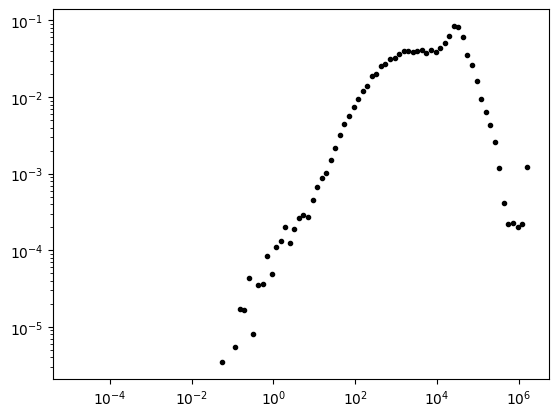

In [ ]:
energies = ((df['energy high [eV]'])-(df['energy low [eV]']))/2
ratio = df['mean']

plt.plot(energies, ratio, 'k.')
plt.xscale('log')
plt.yscale('log')
plt.show

#Rough plot of the TBR against energy.

In [ ]:
#prints the values so that they can be copied and plotted more tidily.

print(tbr_values)

[array([[[7.78720809e-06]],

       [[1.81107403e-05]],

       [[0.00000000e+00]],

       [[4.74883910e-05]],

       [[5.22282221e-05]],

       [[3.21444445e-05]],

       [[2.84276184e-05]],

       [[2.68446497e-05]],

       [[2.59162877e-05]],

       [[2.42335660e-05]],

       [[4.09527280e-05]],

       [[4.45996231e-05]],

       [[3.97652022e-05]],

       [[1.09926727e-04]],

       [[5.33332065e-05]],

       [[1.06869429e-04]],

       [[1.24850890e-04]],

       [[8.47590532e-05]],

       [[1.10069265e-04]],

       [[1.34517861e-04]],

       [[1.72631606e-04]],

       [[1.66358069e-04]],

       [[1.76603890e-04]],

       [[1.94578573e-04]],

       [[1.76639951e-04]],

       [[2.31712823e-04]],

       [[3.32608910e-04]],

       [[4.94126140e-04]],

       [[4.71678099e-04]],

       [[5.77737300e-04]],

       [[7.22766728e-04]],

       [[8.28092175e-04]],

       [[1.13642829e-03]],

       [[1.26259758e-03]],

       [[1.69632610e-03]],

       [[2.17118131

# Multiple Runs

In [ ]:
# Breeder Blanket Thickness Sweep
# (This script assumes 'output_dir' is a pathlib.Path object
#  defined in a previous cell)

print(f"--- Starting Breeder Blanket Thickness Sweep ---")
print(f"All simulation outputs will be written to: {output_dir}")

avg_thickenss = 75  # blanket thickness in centimeters, standard value of 75cm
triangularity = 0.55  # triangularity, standard value of 0.55

#enrichment_values = np.arange(5, 96, 5)
#thickness_values = thickness_multipliers * avg_thickenss/100
#triangularity_values = np.arange(0.05, 1.01, 0.05)
coolant_fraction = np.arange(0.00, 0.96, 0.05)
tbr_values = []
tbr_errors = []
li6_values = []
li7_values = []

for i in solid_breeders:
    print(f"\n--- Running simulation for coolant fraction: {i} ---")

    # --- NEW: Aggressive cleanup of old files ---
    # This deletes files from the *previous* iteration to prevent conflicts,
    # as you requested.
    print(f"Cleaning output directory: {output_dir}")
    extensions_to_remove = ['*.h5', '*.h5m', '*.xml', '*.out']
    files_removed = 0
    for ext in extensions_to_remove:
        for f in output_dir.glob(ext):
            try:
                f.unlink()
                files_removed += 1
            except OSError as e:
                print(f"Warning: Could not remove {f.name}. Error: {e}")
    print(f"Removed {files_removed} old files.")
    # --- END OF CLEANUP ---

    # --- 1. Model Setup (Unchanged) ---
    reactor, material_tags, radial_build_list = basic_tokamak(paramak_colors)
    settings_i, tallies_i = settings_code(radial_build_list)
    materials, materials_list = materials_listings(material_tags, b_mat = i)

    my_model = openmc.Model(
        geometry=geometry_code(converter_code(reactor, material_tags)),
        materials=materials_list,
        settings=settings_i,
        tallies=tallies_i
    )

    # --- 2. Run simulation in the correct output directory (Unchanged) ---
    print(f"Running OpenMC in: {output_dir}")
    statepoint_file = my_model.run(cwd=output_dir)
    print(f"Statepoint file created: {statepoint_file}")

    # --- 3. Load statepoint file using a 'with' statement ---
    #
    #    THIS IS THE CRITICAL FIX.
    #
    #    Using 'with' ensures the statepoint file is properly closed
    #    and the file lock is released *before* the loop continues
    #    to the next iteration.
    print(f"Loading statepoint: {statepoint_file} to extract results...")
    with openmc.StatePoint(statepoint_file) as sp:
        tbr_cell_tally = sp.get_tally(name='tbr')

        df = tbr_cell_tally.get_pandas_dataframe()

        tbr_mean = tbr_cell_tally.mean.sum()
        tbr_std_dev = tbr_cell_tally.std_dev.sum()

        tbr_li6 = df[df['nuclide'] == 'Li6']['mean'].sum()
        tbr_li7 = df[df['nuclide'] == 'Li7']['mean'].sum()

        tbr_values.append(tbr_mean)
        tbr_errors.append(tbr_std_dev)
        li6_values.append(tbr_li6)
        li7_values.append(tbr_li7)

    # By this point, the statepoint.10.h5 file is closed.
    print(f"TBR for triangularity {i}: {tbr_mean:.4f} +/- {tbr_std_dev:.4f}")
    print("--- ITERATION COMPLETED ---\n\n")

print("\n\n--- SWEEP COMPLETED ---")
print("Breeders:", solid_names)
print("TBR Values:", tbr_values)
print("TBR Errors:", tbr_errors)
print('Li6 TBR:', li6_values)
print('Li7 TBR:', li7_values)

import pandas as pd
df = pd.DataFrame({'Total': tbr_values,
                   'Varience': tbr_errors,
                   'Li6': li6_values,
                   'Li7': li7_values},
                  index=solid_names)

print(df)


--- Starting Breeder Blanket Thickness Sweep ---
All simulation outputs will be written to: /home/d63657rp/fusion-neutronics-modelling/outputs

--- Running simulation for coolant fraction: Material
	ID             =	400
	Name           =	
	Temperature    =	None
	Density        =	2.1 [g/cm3]
	Volume         =	None [cm^3]
	Depletable     =	False
	S(a,b) Tables  
	Nuclides       
	Li6            =	1.2          [ao]
	Li7            =	0.8          [ao]
	O16            =	0.9976206    [ao]
	O17            =	0.000379     [ao]
	O18            =	0.0020004    [ao]
 ---
Cleaning output directory: /home/d63657rp/fusion-neutronics-modelling/outputs
Removed 5 old files.
Defining OpenMC settings...
Placing source at approximate major radius: 376.66666666666663 cm
Settings defined.
Converting CAD to DAGMC...


Info    : Meshing 1D...
Info    : [  0%] Meshing curve 2 (Circle)
Info    : [  0%] Meshing curve 4 (Line)
Info    : [  0%] Meshing curve 7 (Line)
Info    : [  0%] Meshing curve 13 (Circle)
Info    : [  0%] Meshing curve 12 (Line)
Info    : [  0%] Meshing curve 6 (Line)
Info    : [  0%] Meshing curve 21 (Circle)
Info    : [  0%] Meshing curve 10 (Line)
Info    : [ 10%] Meshing curve 17 (Line)
Info    : [ 10%] Meshing curve 30 (BSpline)
Info    : [ 10%] Meshing curve 27 (BSpline)
Info    : [  0%] Meshing curve 11 (Line)
Info    : [  0%] Meshing curve 9 (Line)
Info    : [ 10%] Meshing curve 1 (Circle)
Info    : [  0%] Meshing curve 5 (Circle)
Info    : [ 10%] Meshing curve 45 (Circle)
Info    : [ 10%] Meshing curve 46 (BSpline)
Info    : [ 10%] Meshing curve 16 (Circle)
Info    : [ 10%] Meshing curve 19 (Line)
Info    : [ 10%] Meshing curve 15 (Line)
Info    : [ 10%] Meshing curve 25 (BSpline)
Info    : [ 10%] Meshing curve 36 (BSpline)
Info    : [ 10%] Meshing curve 29 (BSpline)
Info    

Info    : Done meshing 2D (Wall 34.5434s, CPU 133.984s)
Info    : 43440 nodes 89337 elements
written DAGMC file /home/d63657rp/fusion-neutronics-modelling/outputs/dagmc_reactor.h5m
Successfully created /home/d63657rp/fusion-neutronics-modelling/outputs/dagmc_reactor.h5m
Running OpenMC in: /home/d63657rp/fusion-neutronics-modelling/outputs
                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
               

Info    : Done meshing 2D (Wall 33.3513s, CPU 132.928s)
Info    : 43394 nodes 89245 elements
written DAGMC file /home/d63657rp/fusion-neutronics-modelling/outputs/dagmc_reactor.h5m
Successfully created /home/d63657rp/fusion-neutronics-modelling/outputs/dagmc_reactor.h5m
Running OpenMC in: /home/d63657rp/fusion-neutronics-modelling/outputs
                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
               

Info    : Done meshing 2D (Wall 33.7398s, CPU 138.48s)
Info    : 43417 nodes 89291 elements
written DAGMC file /home/d63657rp/fusion-neutronics-modelling/outputs/dagmc_reactor.h5m
Successfully created /home/d63657rp/fusion-neutronics-modelling/outputs/dagmc_reactor.h5m
Running OpenMC in: /home/d63657rp/fusion-neutronics-modelling/outputs
                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                

Info    : Done meshing 2D (Wall 32.8104s, CPU 134.324s)
Info    : 43444 nodes 89345 elements
written DAGMC file /home/d63657rp/fusion-neutronics-modelling/outputs/dagmc_reactor.h5m
Successfully created /home/d63657rp/fusion-neutronics-modelling/outputs/dagmc_reactor.h5m
Running OpenMC in: /home/d63657rp/fusion-neutronics-modelling/outputs
                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
               

Info    : Done meshing 2D (Wall 32.4996s, CPU 136.481s)
Info    : 43417 nodes 89291 elements
written DAGMC file /home/d63657rp/fusion-neutronics-modelling/outputs/dagmc_reactor.h5m
Successfully created /home/d63657rp/fusion-neutronics-modelling/outputs/dagmc_reactor.h5m
Running OpenMC in: /home/d63657rp/fusion-neutronics-modelling/outputs
                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
               

Info    : Done meshing 2D (Wall 33.8399s, CPU 137.388s)
Info    : 43430 nodes 89317 elements
written DAGMC file /home/d63657rp/fusion-neutronics-modelling/outputs/dagmc_reactor.h5m
Successfully created /home/d63657rp/fusion-neutronics-modelling/outputs/dagmc_reactor.h5m
Running OpenMC in: /home/d63657rp/fusion-neutronics-modelling/outputs
                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
               

Info    : Done meshing 2D (Wall 34.4939s, CPU 132.173s)
Info    : 43427 nodes 89311 elements
written DAGMC file /home/d63657rp/fusion-neutronics-modelling/outputs/dagmc_reactor.h5m
Successfully created /home/d63657rp/fusion-neutronics-modelling/outputs/dagmc_reactor.h5m
Running OpenMC in: /home/d63657rp/fusion-neutronics-modelling/outputs
                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
               

Info    : Done meshing 2D (Wall 34.6454s, CPU 137.789s)
Info    : 43460 nodes 89377 elements
written DAGMC file /home/d63657rp/fusion-neutronics-modelling/outputs/dagmc_reactor.h5m
Successfully created /home/d63657rp/fusion-neutronics-modelling/outputs/dagmc_reactor.h5m
Running OpenMC in: /home/d63657rp/fusion-neutronics-modelling/outputs
                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
               

Info    : Done meshing 2D (Wall 34.3099s, CPU 139.724s)
Info    : 43387 nodes 89231 elements
written DAGMC file /home/d63657rp/fusion-neutronics-modelling/outputs/dagmc_reactor.h5m
Successfully created /home/d63657rp/fusion-neutronics-modelling/outputs/dagmc_reactor.h5m
Running OpenMC in: /home/d63657rp/fusion-neutronics-modelling/outputs
                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
               

Info    : Done meshing 2D (Wall 32.4878s, CPU 133.673s)
Info    : 43416 nodes 89289 elements
written DAGMC file /home/d63657rp/fusion-neutronics-modelling/outputs/dagmc_reactor.h5m
Successfully created /home/d63657rp/fusion-neutronics-modelling/outputs/dagmc_reactor.h5m
Running OpenMC in: /home/d63657rp/fusion-neutronics-modelling/outputs
                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
               

Info    : Done meshing 2D (Wall 33.5854s, CPU 133.756s)
Info    : 43420 nodes 89297 elements
written DAGMC file /home/d63657rp/fusion-neutronics-modelling/outputs/dagmc_reactor.h5m
Successfully created /home/d63657rp/fusion-neutronics-modelling/outputs/dagmc_reactor.h5m
Running OpenMC in: /home/d63657rp/fusion-neutronics-modelling/outputs
                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
               

Info    : Done meshing 2D (Wall 35.5529s, CPU 139.938s)
Info    : 43449 nodes 89355 elements
written DAGMC file /home/d63657rp/fusion-neutronics-modelling/outputs/dagmc_reactor.h5m
Successfully created /home/d63657rp/fusion-neutronics-modelling/outputs/dagmc_reactor.h5m
Running OpenMC in: /home/d63657rp/fusion-neutronics-modelling/outputs
                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
               

Info    : Done meshing 2D (Wall 33.2468s, CPU 133.269s)
Info    : 43395 nodes 89247 elements
written DAGMC file /home/d63657rp/fusion-neutronics-modelling/outputs/dagmc_reactor.h5m
Successfully created /home/d63657rp/fusion-neutronics-modelling/outputs/dagmc_reactor.h5m
Running OpenMC in: /home/d63657rp/fusion-neutronics-modelling/outputs
                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
               

Info    : Done meshing 2D (Wall 33.1042s, CPU 130.399s)
Info    : 43416 nodes 89289 elements
written DAGMC file /home/d63657rp/fusion-neutronics-modelling/outputs/dagmc_reactor.h5m
Successfully created /home/d63657rp/fusion-neutronics-modelling/outputs/dagmc_reactor.h5m
Running OpenMC in: /home/d63657rp/fusion-neutronics-modelling/outputs
                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
               

Info    : Done meshing 2D (Wall 34.2238s, CPU 135.067s)
Info    : 43371 nodes 89199 elements
written DAGMC file /home/d63657rp/fusion-neutronics-modelling/outputs/dagmc_reactor.h5m
Successfully created /home/d63657rp/fusion-neutronics-modelling/outputs/dagmc_reactor.h5m
Running OpenMC in: /home/d63657rp/fusion-neutronics-modelling/outputs
                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
               

Info    : Done meshing 2D (Wall 34.5071s, CPU 135.771s)
Info    : 43368 nodes 89193 elements
written DAGMC file /home/d63657rp/fusion-neutronics-modelling/outputs/dagmc_reactor.h5m
Successfully created /home/d63657rp/fusion-neutronics-modelling/outputs/dagmc_reactor.h5m
Running OpenMC in: /home/d63657rp/fusion-neutronics-modelling/outputs
                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
               

Info    : Done meshing 2D (Wall 32.9246s, CPU 132.054s)
Info    : 43425 nodes 89307 elements
written DAGMC file /home/d63657rp/fusion-neutronics-modelling/outputs/dagmc_reactor.h5m
Successfully created /home/d63657rp/fusion-neutronics-modelling/outputs/dagmc_reactor.h5m
Running OpenMC in: /home/d63657rp/fusion-neutronics-modelling/outputs
                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
               

Info    : Done meshing 2D (Wall 33.3753s, CPU 134.259s)
Info    : 43420 nodes 89297 elements
written DAGMC file /home/d63657rp/fusion-neutronics-modelling/outputs/dagmc_reactor.h5m
Successfully created /home/d63657rp/fusion-neutronics-modelling/outputs/dagmc_reactor.h5m
Running OpenMC in: /home/d63657rp/fusion-neutronics-modelling/outputs
                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
               

Info    : Done meshing 2D (Wall 33.8517s, CPU 131.573s)
Info    : 43439 nodes 89335 elements
written DAGMC file /home/d63657rp/fusion-neutronics-modelling/outputs/dagmc_reactor.h5m
Successfully created /home/d63657rp/fusion-neutronics-modelling/outputs/dagmc_reactor.h5m
Running OpenMC in: /home/d63657rp/fusion-neutronics-modelling/outputs
                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
               

In [ ]:
#thickness_values = thickness_multipliers * avg_thickenss/100


plt.plot(coolant_fraction, tbr_values, 'k.')
plt.errorbar(coolant_fraction, tbr_values, tbr_errors, fmt='k.')

plt.title('TBR with Varying Coolant Content')
plt.xlabel('Helium Content by Volume')
plt.ylabel('TBR')
plt.grid()

plt.show()

In [ ]:
# table

import pandas as pd

df = pd.DataFrame({'Total': tbr_values,
                   'Varience': tbr_errors,
                   'Li6': li6_values,
                   'Li7': li7_values},
                  index=liquid_names)

print(df)


                  Total  Varience       Li6       Li7
Li             1.366866  0.004580  1.331549  0.035316
Li17Pb83       1.428071  0.004350  1.425869  0.002201
LiF_BeF2       1.326421  0.004124  1.314074  0.012347
Li_BeF2*       1.327510  0.004437  1.318938  0.008572
LiF_PbF2       1.341919  0.003181  1.338692  0.003226
Li3N           1.339094  0.003866  1.304138  0.034955
LiF            1.362015  0.004566  1.328312  0.033703
LiF_BeF2_NaF   1.294823  0.003029  1.289198  0.005625
LiF_NaF_ZrF4   1.285219  0.003704  1.278135  0.007085
LiF_NaF_KF     1.251945  0.003635  1.244506  0.007439
LiCl_NaCl      1.218140  0.004174  1.209266  0.008874
LiCl_KCl       1.195608  0.003833  1.187642  0.007966
LiCl_KCl*      1.149211  0.003348  1.143797  0.005414
LiCl_BeCl2     1.135646  0.003464  1.130737  0.004909
LiF_LiI2       1.098762  0.002931  1.083155  0.015606
LiCl_PbCl2     1.069324  0.002724  1.067102  0.002222
LiF_LiBr_NaF   1.022902  0.002947  1.010593  0.012309
LiF_LiBr_NaBr  1.018806  0.0